
# Time Series Analysis

Having perviously worked on a couple Time Series models, I discovered that I have a fondness or perference on building these models, due to the insights that you can derive from the change of life in regards to time. It is very fascinating and now one of my favorite to work with, the other is NLP, another field of specialization that I tend to focus on.


For this article we will use a new tool for me, but one that I find very useful, and effective. The tool that we will be using is **PyCaret**. Introduced to me through a Kaggle colleague [Mario Ceasar](https://linktr.ee/caesarmario_), a very good Data Scientist.

PyCaret is low code, which for me as an early stage Data Scientist/Engineer, is extremely beneficial.

In [24]:
# 
import os
import pandas as pd
import seaborn as sns

# Visualizations
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
%matplotlib inline
import plotly.graph_objects as go
import plotly.express as px
from pylab import rcParams
from plotly import tools
import plotly
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

# Stats model package
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [25]:
# Bring in our dataset that we will use to derive our insights
ces_gov_emp = pd.read_csv('/Users/jasonrobinson/Documents/Projects/bls_project/data_2/SeriesReport-ces-government.csv')
cpi_u = pd.read_csv('/Users/jasonrobinson/Documents/Projects/bls_project/data_2/SeriesReport-cpi-all-u-notadj.48.csv')
cpi_w = pd.read_csv('/Users/jasonrobinson/Documents/Projects/bls_project/data_2/SeriesReport-cpi-urbwage-notadj.48.csv')
ces_nf = pd.read_csv('/Users/jasonrobinson/Documents/Projects/bls_project/data_2/SeriesReport-ces-total-nonfarm.csv')

print('SHAPE OF OUR DATASETS:')
print('Consumer Price Index for All Urban:',cpi_u.shape)
print('Consumer Price Index for All Wages:', cpi_w.shape)
print('Consumer Expenditure Survey Nonfarm:', ces_nf.shape)
print('CES for Government Employees:',ces_gov_emp.shape)

SHAPE OF OUR DATASETS:
Consumer Price Index for All Urban: (75, 13)
Consumer Price Index for All Wages: (75, 15)
Consumer Expenditure Survey Nonfarm: (11, 13)
CES for Government Employees: (11, 13)


In [26]:
# ***CPI(ONLY)***
cpi = pd.read_csv('/Users/jasonrobinson/Documents/Projects/bls_project/data/cpi_analysis_22.csv')
print('\n',"Series ID: CUUR0000SA0",'\n',"Consumer Price Index")
print('', cpi.shape)
cpi.head()


 Series ID: CUUR0000SA0 
 Consumer Price Index
 (145, 5)


,Series ID,Year,Period,Label,Value
0,CUUR0000SA0,2010,M01,2010 Jan,216.687
1,CUUR0000SA0,2010,M02,2010 Feb,216.741
2,CUUR0000SA0,2010,M03,2010 Mar,217.631
3,CUUR0000SA0,2010,M04,2010 Apr,218.009
4,CUUR0000SA0,2010,M05,2010 May,218.178


In [27]:
new_cpi = cpi[['Year', 'Value']]
new_cpi

,Year,Value
0,2010,216.687
1,2010,216.741
2,2010,217.631
3,2010,218.009
4,2010,218.178
...,...,...
140,2021,274.310
141,2021,276.589
142,2021,277.948
143,2021,278.802


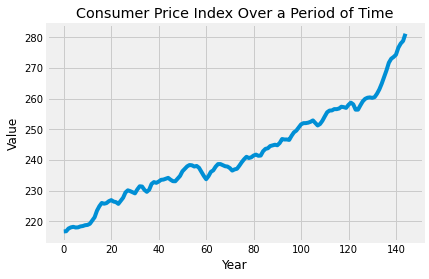

In [28]:
cpi["Value"].plot() # asfreq method is used to convert a time series to a specified frequency. Here it is monthly frequency.
plt.title('Consumer Price Index Over a Period of Time')
plt.xlabel("Year")
plt.ylabel("Value")
plt.show()

As we can see over time the CPI has a steady increase, with consistent changes in movements. The large spike and trend shift appears to have occurred within the last 1-2 years; however, further investigation will tell us more.

In [29]:
# We can take a look at the discrete sequences of the data
fig = px.line(new_cpi, x='Year', y='Value', title='Consumer Price Index',
              labels={'Year': 'Year', 'Value': 'Consumer Price Index'})

fig.update_layout(
    title_text='Consumer Price Index',
    xaxis_title_text="Year",
    yaxis_title_text="Value",
    font=dict(
        family="Courier New, monospace",
        size=14,
        color = '#1f77b4'
    )
)
iplot(fig)

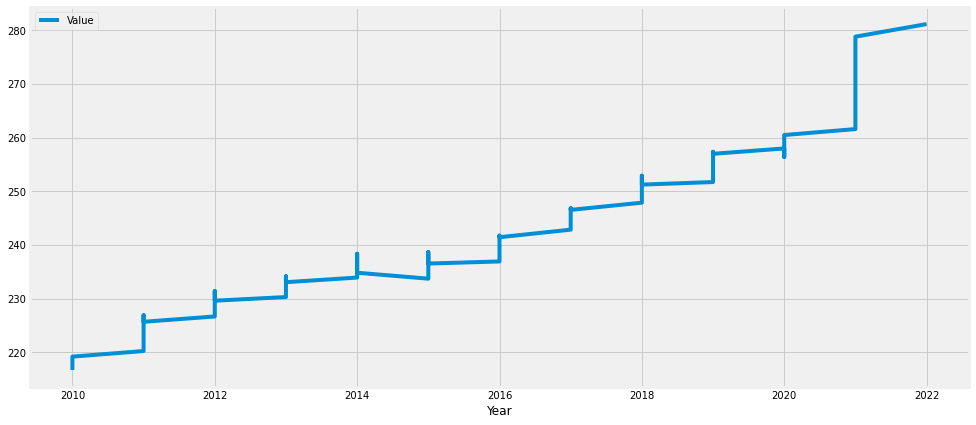

In [30]:
new_cpi.columns=["Year","Value"]
new_cpi.head()
new_cpi.describe()
new_cpi.set_index(['Year'],inplace=True)

from pylab import rcParams
rcParams['figure.figsize'] = 15, 7
new_cpi.plot();

What does this say about our data?

We can clearly determine that there is some form of seasonality or cyclic behavior during specific intervals.The spike in 2021 is likely a result or display of inflation, as consumers are required to spend more for the goods and services that they consume. 

Let's drill down on that period, and see if there is a relationship to other factors such as **Consumer Expenditure Spending** for total nonfarm residents.

In [88]:
ces_total_nf.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2012,133250,133512,133752.0,133834.0,133934.0,134007.0,134159.0,134331.0,134518.0,134677.0,134833.0,135072.0
1,2013,135263,135541,135680.0,135871.0,136093.0,136274.0,136386.0,136628.0,136815.0,137040.0,137304.0,137373.0
2,2014,137548,137714,137968.0,138293.0,138511.0,138837.0,139069.0,139257.0,139566.0,139818.0,140109.0,140377.0
3,2015,140568,140839,140910.0,141194.0,141525.0,141699.0,142001.0,142126.0,142281.0,142587.0,142824.0,143097.0
4,2016,143205,143417,143654.0,143851.0,143892.0,144150.0,144521.0,144664.0,144953.0,145071.0,145201.0,145415.0


In [ ]:
ces_total_nf.head()

In [ ]:
def iterate_months(ces_total_nf):
    # We will iterate through the months
    for i in range(1, len(ces_total_nf)):
    #yeild return our month/year index
        yield df.iloc[i]['Jan'], df.iloc[i]['Year']
        
        
def filter_values(value):
    # Filter the values to .2f
    return round(value, 2)

In [60]:
fig = px.line(ces_total_nf, x='Year', y='Jun', title='Consumer Price Index',
              labels={'Year': 'Year', 'Jun': 'Consumer Expenditure Survey'})

fig.update_layout(
    title_text='Consumer Expenditure Survey',
    xaxis_title_text="Year",
    yaxis_title_text="Jun",
    font=dict(
        family="Courier New, monospace",
        size=14,
        color = '#1f77b4'
    )
)
iplot(fig)

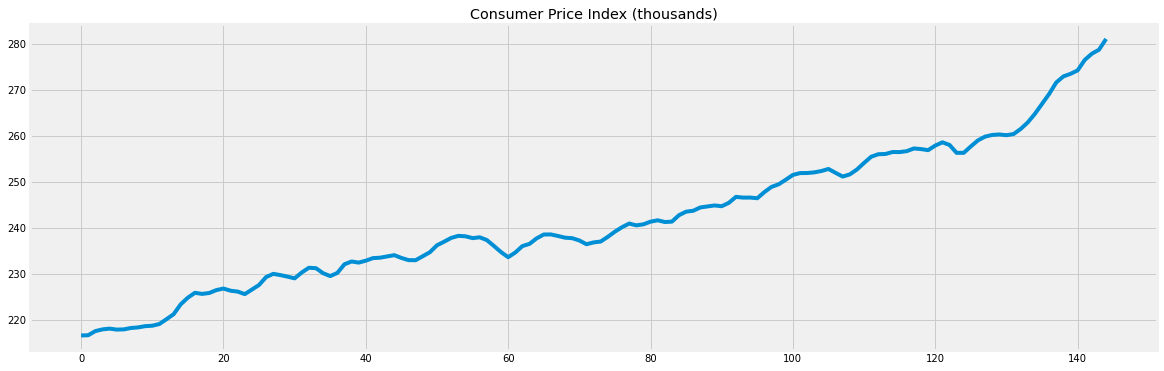

In [63]:
plt.figure(figsize=(18, 6))
plt.plot(cpi.Value)
plt.title('Consumer Price Index (thousands)')
plt.grid(True)
plt.show()

The data appears to show a drop in spending per household for goods and services. Beginning in line to when the pandemic first began in the U.S.


## SARIMA

SARIMA a modeling method that is an extension of ARIMA method. SARIMA is much like it's namesake; however, it incorporates Seasonal Autoregression Modeling Average.


In [12]:
import warnings                                  # do not disturbe mode
warnings.filterwarnings('ignore')

# Load packages
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

# Importing everything from forecasting quality metrics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [13]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()


## Resampling



##  Forecasting Univariate Data

In forecasting univarite data we can better assess the volitility or change over a discrete period of time.
